In [254]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
import shortest_path as sp
import sc_pca
import random
import check_coords

In [ ]:
# upload files
# 2 marker gene set
# 3 top k parameters (for 3 of the cell types) - tumor, luminal, myoepithelial
# find and plot top k cells for the 3 cell groups
# pairwise differential expression of 3 groups
# find group representatives - one cell represents that cluster
# for each pair of representative cells, find and show trajectory - and distance will be parameter
# convert trajectory to DE (for the downstream network analysis)

In [7]:
dir = "~/Desktop/Josh_br2/"
# data_file = dir + "normalized_mat.tsv"

In [14]:
norm_mat = pd.read_table(dir + "normalized_mat.tsv", index_col=0)

In [19]:
umap_coords = pd.read_table(dir + "umap_coords.tsv", index_col=0)

In [239]:
pca_coords = pd.read_table(dir + "pca_coords.tsv", index_col=0,usecols=[0,1,2,3,4,5,6,7])

In [240]:
pca_coords.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
midpoint_2022_AAACGCTGTGTAAATG-1,12.570557,-1.560516,-0.321109,1.481060,0.351270,-6.052600,-0.323439
midpoint_2022_AAAGAACTCCAACTAG-1,11.675000,-1.310510,0.823966,3.270171,1.314359,-8.668641,0.827346
midpoint_2022_AAAGAACTCTTCTGTA-1,12.054394,-0.591662,0.051444,3.523285,2.693378,-8.701379,-0.742966
midpoint_2022_AAAGGATTCAAGCCAT-1,10.514706,2.767524,-1.067258,-0.561062,-2.292628,-2.877209,1.232073
midpoint_2022_AAAGGGCTCCGTGGGT-1,12.517384,-10.095679,-0.302902,-2.930189,1.313240,7.650752,-0.429542


In [33]:
norm_mat.head()

,midpoint_2022_AAACGCTGTGTAAATG.1,midpoint_2022_AAAGAACTCCAACTAG.1,midpoint_2022_AAAGAACTCTTCTGTA.1,midpoint_2022_AAAGGATTCAAGCCAT.1,midpoint_2022_AAAGGGCTCCGTGGGT.1,midpoint_2022_AAAGGTACATGTCTAG.1,midpoint_2022_AAAGTCCTCAGAGTTC.1,midpoint_2022_AAAGTCCTCCAGCACG.1,midpoint_2022_AAAGTGAGTAAGACCG.1,midpoint_2022_AAATGGAGTCATACCA.1,...,tumor_TTTATGCCAAGCCTAT.1,tumor_TTTATGCGTGCAGTAG.1,tumor_TTTATGCTCGCCTGAG.1,tumor_TTTCCTCCAAGTTCTG.1,tumor_TTTCCTCCACCAGTTA.1,tumor_TTTCCTCGTATGCTTG.1,tumor_TTTGCGCCACGGTTTA.1,tumor_TTTGGTTCAGCCTGTG.1,tumor_TTTGGTTCAGTGAGTG.1,tumor_TTTGGTTGTGCAACTT.1
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mrpl15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.467282,0.908944,0.0,1.121759,0.355743,0.244490,0.379996,0.485346,0.984984,0.361297
Lypla1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.181113,0.687029,0.0,0.296425,0.000000,0.440794,0.379996,0.485346,0.696472,0.361297
Tcea1,0.0,0.0,0.0,0.0,0.0,0.0,1.583395,0.928307,0.0,1.065727,...,0.334399,0.401390,0.0,0.296425,0.355743,0.244490,0.768113,0.271833,0.289346,0.196877


In [205]:
norm_mat.columns = norm_mat.columns.str.replace(".","-")

/var/folders/d6/2j75n7jj3_7cnfyfppyydl1m0000gn/T/ipykernel_41166/2120222367.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  norm_mat.columns = norm_mat.columns.str.replace(".","-")


In [34]:
umap_coords.head()

,UMAP_1,UMAP_2
midpoint_2022_AAACGCTGTGTAAATG-1,-3.727179,-1.020334
midpoint_2022_AAAGAACTCCAACTAG-1,-1.653312,-0.577389
midpoint_2022_AAAGAACTCTTCTGTA-1,-1.313342,-0.625920
midpoint_2022_AAAGGATTCAAGCCAT-1,-5.610435,0.519023
midpoint_2022_AAAGGGCTCCGTGGGT-1,-9.204740,-5.912003


In [8]:
luminal_progenitor = ["Elf5", "Cd14", "Kit", "Aldh1a1", "Aldh1a3", "Foxc1", "Foxc2", "Itga2", "Itgb3", "Tspan8", "Cd55",
                      "Fabp7"]

myoepithelial = ["Moxd1", "Ncam1", "Nes", "Ngfr", "Nrg1", "Nt5e", "Oxtr", "Pard3b", "Pdpn", "Procr", "Pygo2", "Sfrp1",
                 "Snai1", "Snai2", "Snai3", "Taz", "Tgfbr1", "Tgfbr2", "Tgfbr3", "Trp53", "Trp63", "Twist1", "Twist2",
                 "Wif1", "Wnt10a", "Wnt11", "Wnt6", "Zeb1", "Zeb2", "Krt5", "Krt14", "Krt17", "Cd44", "Vim", "Acta2",
                 "Sparc", "Myh11", "Myl9", "Mylk", "Cdh2", "Cdh3", "Mmp3", "Mmp9", "Igfbp4", "Fn1", "Col1a1", "Col1a2",
                 "Col3a1", "Serpine1", "Mme", "Axin2", "Itga6", "Itgav", "Lgr5", "Lgr6", "Lrp5", "Lrp6", "Icam1",
                 "Cd47", "Id4", "Fzd7", "Runx2", "Cav1", "Msn", "Gng11", "Dkk3", "Bmp7", "Lgals1", "Thy1", "Inpp5d",
                 "Trp73"]

In [9]:
def get_top_k_cells(norm_mat, marker_list, cell_prefix, top_k):

    # subset expression of the marker genes
    marker_exp = norm_mat[norm_mat.index.isin(marker_list)]
    # sum of the marker genes per cell
    marker_exp_sum = marker_exp.sum(axis=0)

    # cells sorted based on their total expression
    sorted_list = marker_exp_sum.sort_values(ascending=False)
    sorted_list = sorted_list[sorted_list.index.isin([c for c in sorted_list.index.to_list() if c.startswith(cell_prefix)])]

    # return sorted k cells
    return sorted_list[0:top_k].index.to_list()

In [244]:
k_basal = 200
k_luminal = 200
k_tumor = 1000

top_luminal = get_top_k_cells(norm_mat, luminal_progenitor, "m", k_luminal)
top_basal = get_top_k_cells(norm_mat, myoepithelial, "m", k_basal)
top_tumor = get_top_k_cells(norm_mat, [],"t", k_tumor)

In [208]:
def plot_cells(selected_cells, umap_coords):

    # umap coordinates of the selected cells (top k cells)
    sub_cell = umap_coords[umap_coords.index.isin(selected_cells)]
    plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.scatter(umap_coords['UMAP_1'], umap_coords['UMAP_2'])

    # scatter warning points in red (c='r')
    ax.plot(sub_cell['UMAP_1'], sub_cell['UMAP_2'], 'o', c='r')
    plt.show()

def plot_marker(norm_mat, umap_coords, marker_list, cell_prefix, top_k):
    selected_cells = get_top_k_cells(norm_mat, marker_list, cell_prefix, top_k)
    plot_cells(selected_cells, umap_coords)

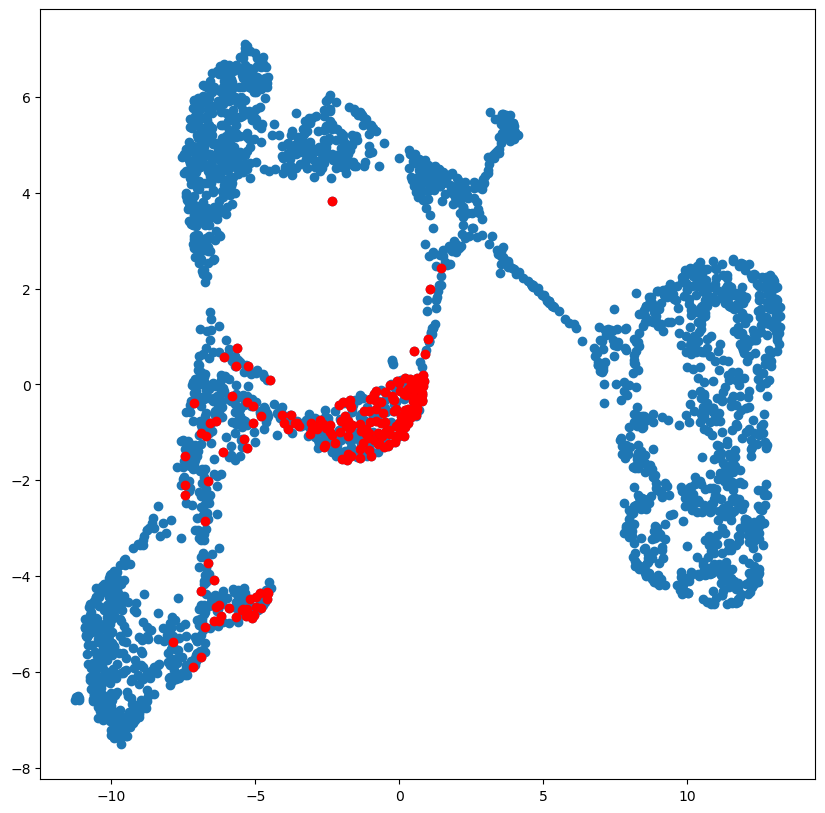

In [245]:
plot_marker(norm_mat, umap_coords, luminal_progenitor, "m", k_luminal)

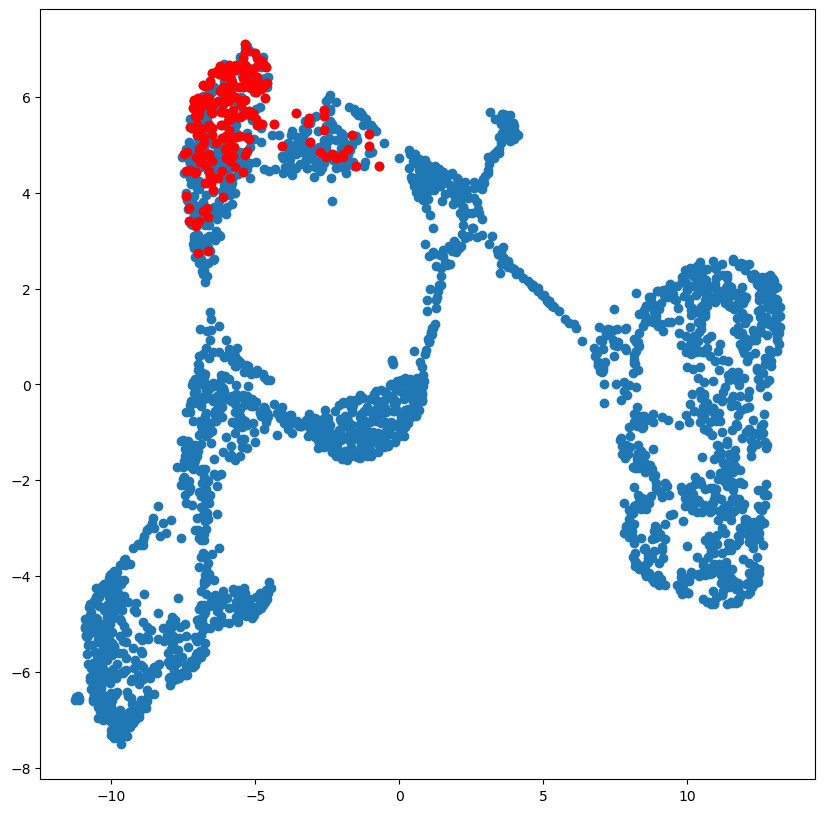

In [246]:
plot_marker(norm_mat, umap_coords, myoepithelial, "m", k_basal)

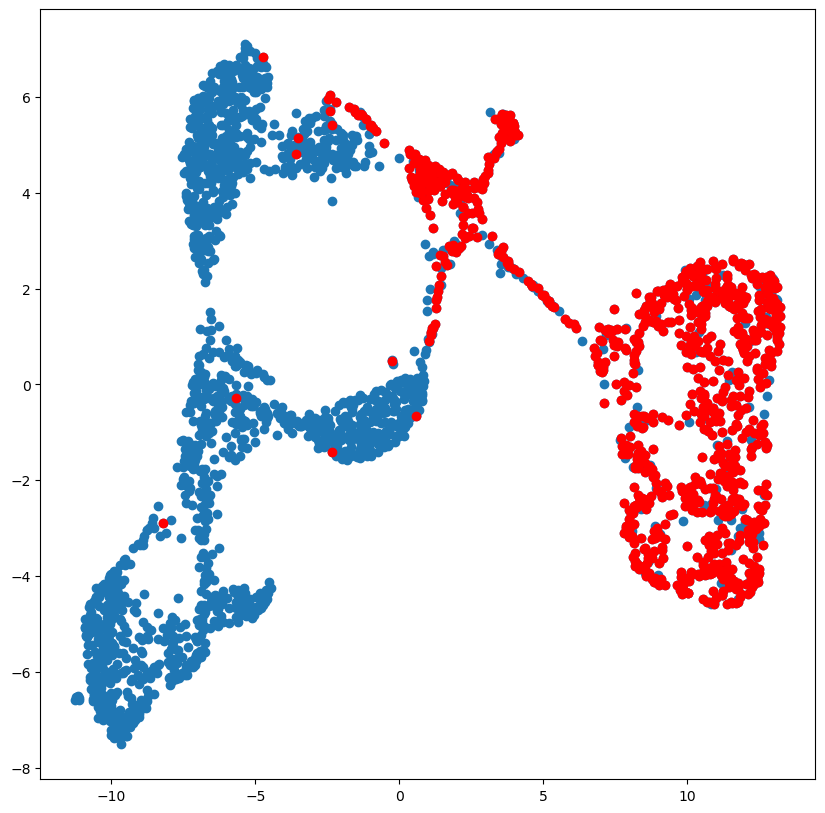

In [247]:
plot_marker(norm_mat, umap_coords, [], "t", k_tumor)

In [251]:
luminal_avg_pt = pca_coords[pca_coords.index.isin(top_luminal)].mean(axis=0)
basal_avg_pt = pca_coords[pca_coords.index.isin(top_basal)].mean(axis=0)
tumor_avg_pt = pca_coords[pca_coords.index.isin(top_tumor)].mean(axis=0)

In [252]:
luminal_avg_pt

PC_1    11.600939
PC_2    -2.768131
PC_3     0.474994
PC_4     3.417416
PC_5     2.780866
PC_6    -7.966089
PC_7    -0.417189
dtype: float64

In [253]:
pca_coords

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
midpoint_2022_AAACGCTGTGTAAATG-1,12.570557,-1.560516,-0.321109,1.481060,0.351270,-6.052600,-0.323439
midpoint_2022_AAAGAACTCCAACTAG-1,11.675000,-1.310510,0.823966,3.270171,1.314359,-8.668641,0.827346
midpoint_2022_AAAGAACTCTTCTGTA-1,12.054394,-0.591662,0.051444,3.523285,2.693378,-8.701379,-0.742966
midpoint_2022_AAAGGATTCAAGCCAT-1,10.514706,2.767524,-1.067258,-0.561062,-2.292628,-2.877209,1.232073
midpoint_2022_AAAGGGCTCCGTGGGT-1,12.517384,-10.095679,-0.302902,-2.930189,1.313240,7.650752,-0.429542
...,...,...,...,...,...,...,...
tumor_TTTCCTCGTATGCTTG-1,-16.320618,0.297138,-2.472342,-3.115796,1.448764,-2.320810,2.917541
tumor_TTTGCGCCACGGTTTA-1,-16.962498,-0.059983,-0.151730,-3.489281,-2.309342,-1.098108,-2.174143
tumor_TTTGGTTCAGCCTGTG-1,-22.684053,-5.798545,-12.880179,9.939476,-7.704790,0.290166,-4.267249
tumor_TTTGGTTCAGTGAGTG-1,-22.571032,-2.129237,-9.509131,0.367345,-0.447589,-1.401662,1.110373


In [257]:
pca_coords.iloc[0]

PC_1    12.570557
PC_2    -1.560516
PC_3    -0.321109
PC_4     1.481060
PC_5     0.351270
PC_6    -6.052600
PC_7    -0.323439
Name: midpoint_2022_AAACGCTGTGTAAATG-1, dtype: float64

In [265]:
pca_coords.iloc[0].name

'midpoint_2022_AAACGCTGTGTAAATG-1'

In [ ]:
# closest cell will be the representative
# use euclidean distance

In [259]:
len(pca_coords)

2786

In [258]:
distance.euclidean(luminal_avg_pt, pca_coords.iloc[0])

4.044121114496043

In [291]:
def find_rep_cell(cell_avg_pt):
    cd = dict()
    for r in range(0,len(pca_coords)):
        cd[pca_coords.iloc[r].name] = distance.euclidean(cell_avg_pt, pca_coords.iloc[r])
    return min(cd, key=cd.get)

In [292]:
find_rep_cell(luminal_avg_pt)

'midpoint_2022_AAGACAATCGGAGTGA-1'

In [293]:
find_rep_cell(tumor_avg_pt)

'tumor_ACATCAGCAGTATCTG-1'

In [294]:
find_rep_cell(basal_avg_pt)

'midpoint_2022_TTCATGTTCATGCAGT-1'

In [300]:
# Plot average points
def plot_RC(selected_cell, umap_coords):

    # umap coordinates of the selected cells (top k cells)
    sub_cell = umap_coords.loc[str(selected_cell)]
    plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.scatter(umap_coords['UMAP_1'], umap_coords['UMAP_2'])

    # scatter warning points in red (c='r')
    ax.plot(sub_cell['UMAP_1'], sub_cell['UMAP_2'], 'o', c='r')
    plt.show()

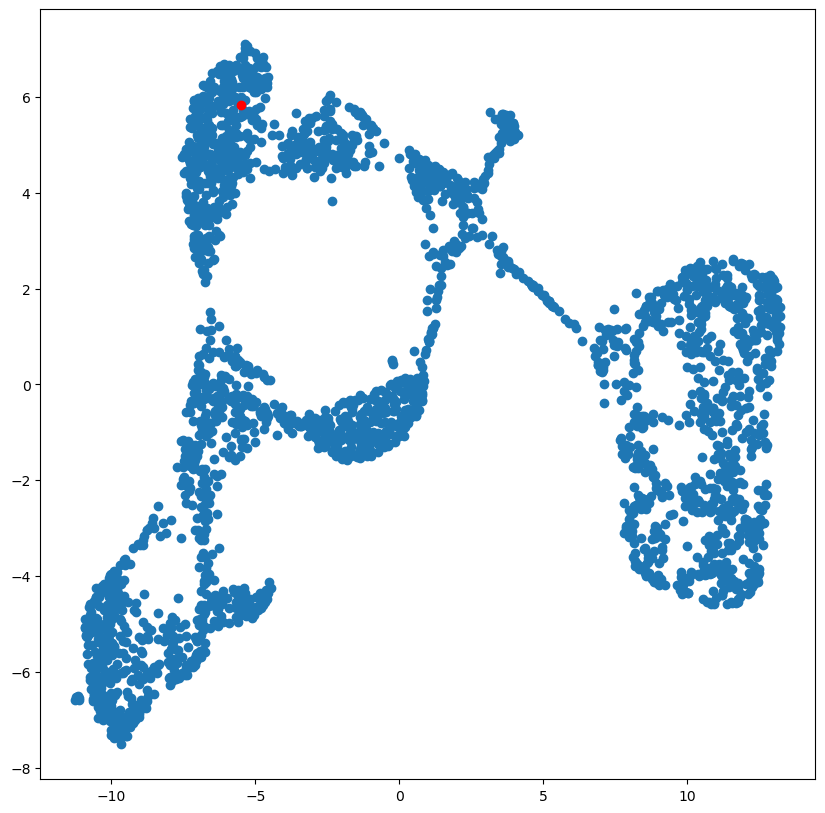

In [301]:
plot_RC('midpoint_2022_TTCATGTTCATGCAGT-1',umap_coords)

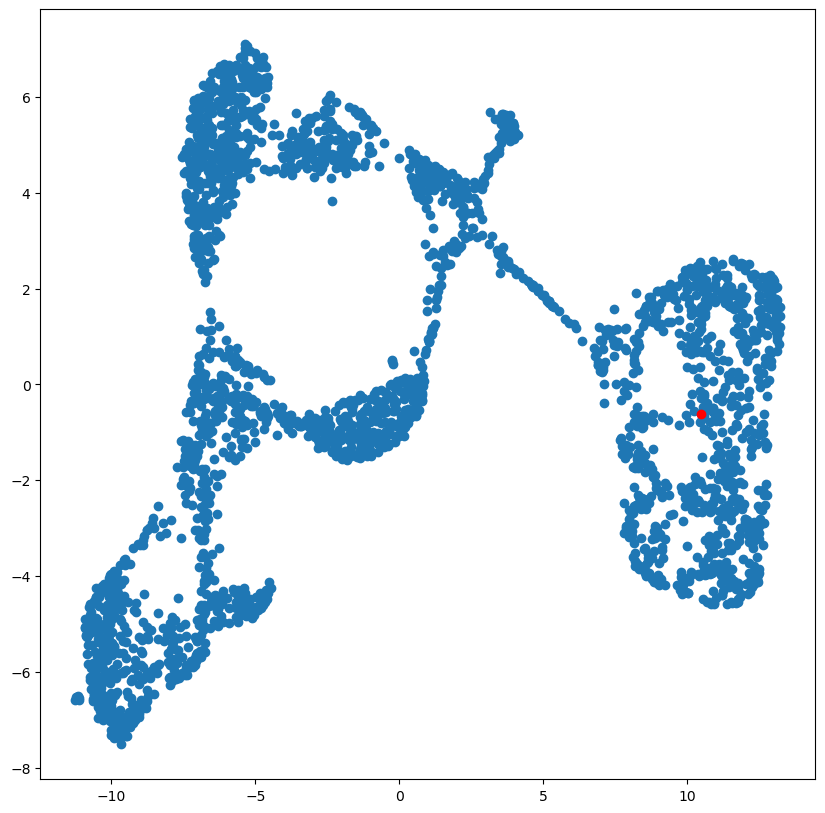

In [302]:
plot_RC('tumor_ACATCAGCAGTATCTG-1',umap_coords)

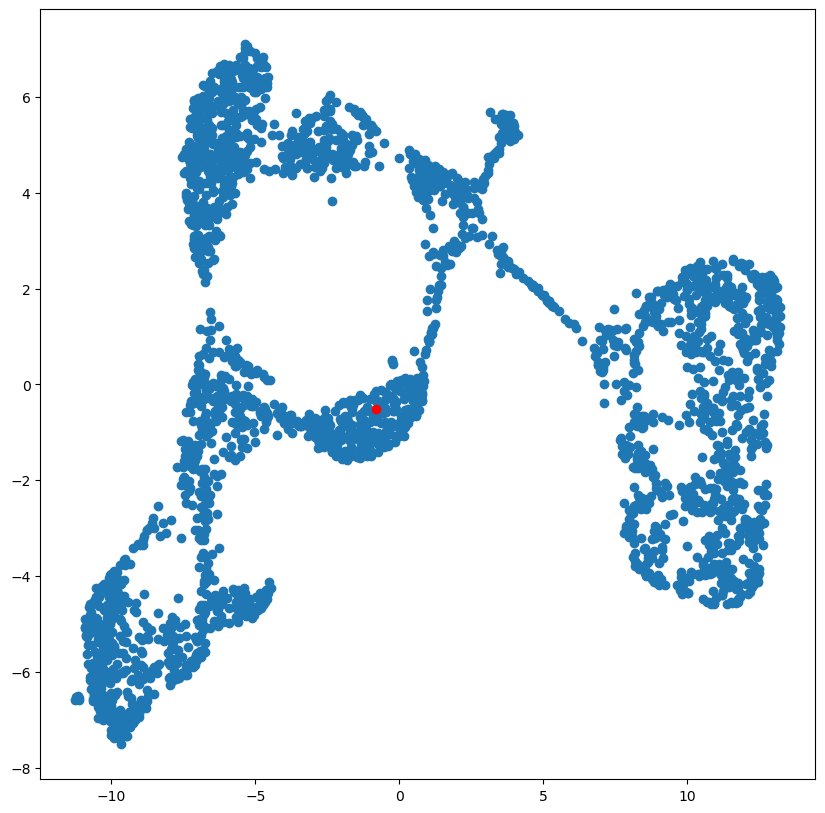

In [303]:
plot_RC('midpoint_2022_AAGACAATCGGAGTGA-1',umap_coords)